
1. load required packages 

2. load calibration files; .poni defining geometry and mask

3. define integrator function



In [1]:
import pyFAI
import baseline
import fabio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pygix as pg

from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from plotnine import *#ggplot, aes, geom_line, labs, theme, ggtitle

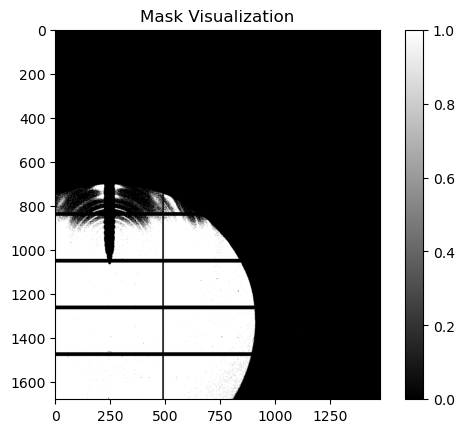

In [2]:
# load the calibration files and visualise mask
poni_file = "/home/goughl/Documents/beamtime_data/2304_DLS/calib/20keV_geometry.poni"
calibration = pyFAI.load(poni_file) # this part done in pyFAI-calib2 GUI (see README)

mask_file = "/home/goughl/Documents/beamtime_data/2304_DLS/calib/mask_AgBh.edf"
mask_data = fabio.open(mask_file).data
mask_data = 1 - mask_data
# invert by commenting out this line

plt.imshow(mask_data, cmap='gray')
plt.colorbar()
plt.title("Mask Visualization")
plt.show()
# black pixels masked, white pixels unmasked, make sure they're the correct way round!! 

In [3]:
# defining all functions to be used
# shouldn't need to change these


# integrator function with arguments defined in pyFAI documentation
integrator = AzimuthalIntegrator(
    detector=calibration.detector,
    wavelength=calibration.wavelength,
    dist=calibration.dist,  
    poni1=calibration.poni1,
    poni2=calibration.poni2,
    rot1=calibration.rot1,
    rot2=calibration.rot2,
    rot3=calibration.rot3
)


# baseline removal 
def asymmetric_least_squares(y, lambda_param, p_param):
    """
    Asymmetric Least Squares Smoothing (Baseline Correction)
    
    Parameters:
        y (array-like): Input signal
        lambda_param (float): Smoothing parameter (penalization)
        p_param (float): Asymmetry parameter
        
    Returns:
        array-like: Baseline corrected signal
    """
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    D = lambda_param * D.dot(D.transpose())
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    Z = W + D
    w = w.reshape(-1, 1)  # Reshape w to match the shape of y
    z = spsolve(Z, w*y)
    return z

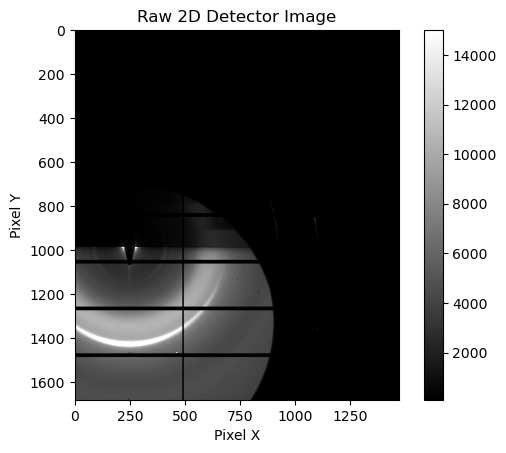

In [4]:
#plot the raw tif image

image = fabio.open("/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure/p2mImage1019682.tif")  # Replace with the actual path to your image file
data = image.data  

vmin = 100  # min intensity value
vmax = 15000  # max intensity value

# for long exposure images (t ~ 30 s) vmax ~ 15000
# for short exposure images (t ~ 3 s) vmax ~ 1000

plt.imshow(data, cmap='gray', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.title('Raw 2D Detector Image')
plt.show()

In [5]:
# check you're in the right folder 
# lists all the files in a directory and puts them in numerical roder

folder_path = r"/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure"

files = [filename for filename in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, filename)) and filename.endswith('.tif')]
sorted_files = sorted(files, key=lambda x: int(x.split("p2mImage")[1].split(".")[0]))

for filename in sorted_files:
    print(filename)

p2mImage1019282.tif
p2mImage1019375.tif
p2mImage1019426.tif
p2mImage1019492.tif
p2mImage1019541.tif
p2mImage1019585.tif
p2mImage1019630.tif
p2mImage1019682.tif


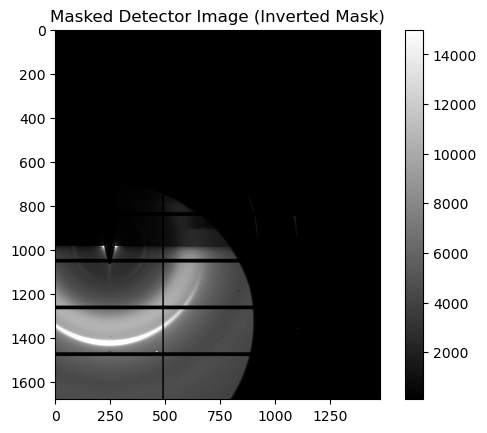

In [6]:
detector_image_file = "/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure/p2mImage1019682.tif"  # Replace with the path to your detector image file
detector_image = fabio.open(detector_image_file).data


mask_file = "/home/goughl/Documents/beamtime_data/2304_DLS/calib/mask_AgBh.edf" # Replace with the path to your mask file
mask_data = fabio.open(mask_file).data

inverted_mask = ~mask_data

# Apply the inverted mask to the detector image
masked_image = np.where(inverted_mask, detector_image, 0)

# Set the intensity range (vmin and vmax)
vmin = 100  # Minimum intensity value
vmax = 15000  # Maximum intensity value

# Plot the masked detector image with specified intensity range
plt.imshow(masked_image, cmap='gray', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title("Masked Detector Image (Inverted Mask)")
plt.show()

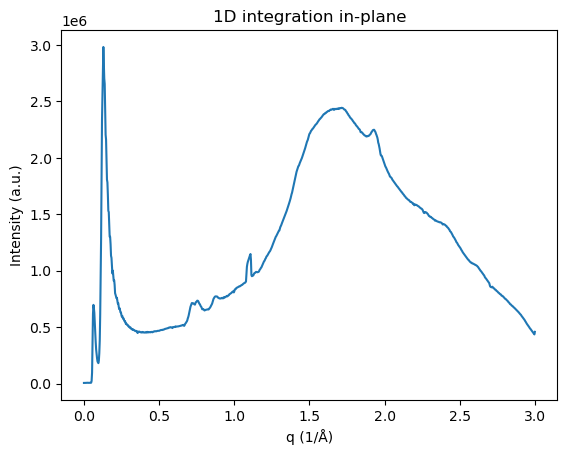

In [75]:
# plot the integrated data (individual)

data_file = "/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure/p2mImage1019682.tif"
data = fabio.open(data_file).data
data = inverted_mask * data
# uncomment the line above to mask

q, I = integrator.integrate1d(data, 1000, unit="q_A^-1", azimuth_range=(0, 30), radial_range=(0.0, 3), polarization_factor=0.99)

# 90 to 120 is out of plane i think??
# 0 to 30 in plane? not 100% sure

plt.plot(q, I)
plt.xlabel("q (1/Å)")
plt.ylabel("Intensity (a.u.)")
plt.title("1D integration in-plane")
plt.show()


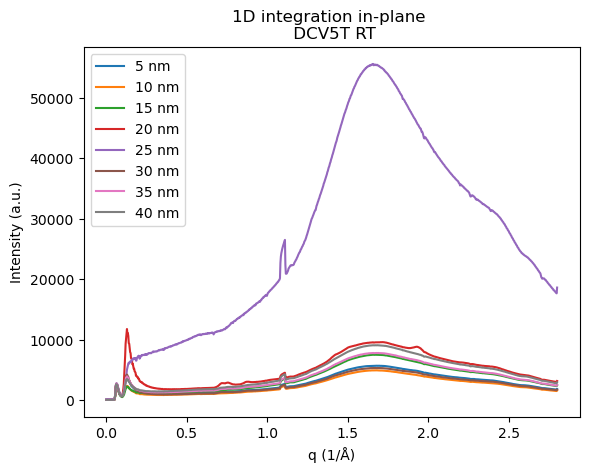

In [8]:
# 1D integrations of all files in a directory
# not normalised

folder_path = r"/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure/"
output_folder = r"/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure"  # Specify the desired output folder
# enter the filepath where you want the CSVs to be saved


qs = []
Is = []
labels = []

start_label = 5
for filename in os.listdir(folder_path):
    if filename.endswith('.tif'):
        data = fabio.open(os.path.join(folder_path, filename)).data
       # data = np.where(inverted_mask, data, 0)
        # can't get the mask to behave properly
        q, I = integrator.integrate1d(data, 1000, unit="q_A^-1", azimuth_range=(0, 30), radial_range=(0, 2.8), polarization_factor=0.99)
        label = start_label + 5 * len(qs)
        qs.append(q)
        Is.append(I)
        labels.append(label)

save = False
# change to true when you want to save the files

if save == True:
    for filename, q, I, label in zip(os.listdir(folder_path), qs, Is, labels):
        data = {'q': q, 'Intensity': I}
        df = pd.DataFrame(data)
        base_filename = os.path.splitext(filename)[0]  
        output_filename = os.path.join(output_folder, f"integration_{base_filename}_{label}nm_unnormalised.csv")
        df.to_csv(output_filename, index=False)

        plt.plot(q, I, label=f"{label} nm")        
else:
    for q, I, label in zip(qs, Is, labels):
        plt.plot(q, I, label=f"{label} nm")

plt.xlabel("q (1/Å)")
plt.ylabel("Intensity (a.u.)")
plt.title("1D integration in-plane \n DCV5T RT")

plt.legend()
plt.show()

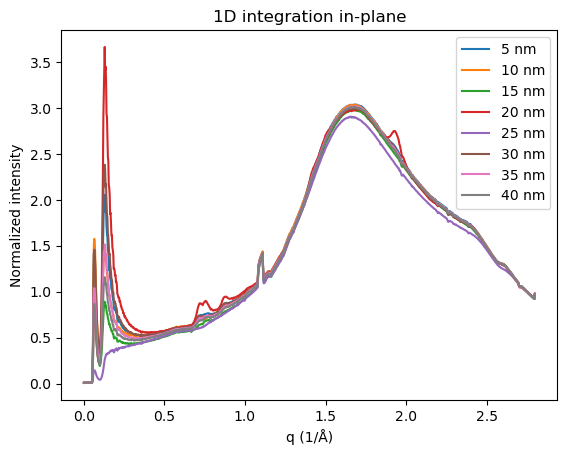

Peak 1 coordinates: q = 2.7482, I = 1869.1415
Peak 2 coordinates: q = 2.7482, I = 1618.4175
Peak 3 coordinates: q = 2.7482, I = 2514.5708
Peak 4 coordinates: q = 2.7482, I = 3206.3953
Peak 5 coordinates: q = 2.7482, I = 19131.2578
Peak 6 coordinates: q = 2.7482, I = 1768.8092
Peak 7 coordinates: q = 2.7482, I = 2579.4932
Peak 8 coordinates: q = 2.7482, I = 3011.5974


In [9]:
# normalising to a chosen point in q space, where you expect to see nothing

background_q = 2.7 # choose a q value where there is only background
bg_range = 0.05 # choose a small range of which background_q is the centre to average


normalized_intensities = []
peak_coordinates = []


for i, (q, I) in enumerate(zip(qs, Is)):
    max_peak = min(I[(q > background_q - bg_range) & (q < background_q + bg_range)])
    max_index = np.argmin(I[(q > background_q - bg_range) & (q < background_q + bg_range)])
    q_max_peak = q[(q > background_q - bg_range) & (q < background_q + bg_range)][max_index]

    normalized_intensity = I / max_peak
    normalized_intensities.append(normalized_intensity)
    peak_coordinates.append((q_max_peak, max_peak))

    plt.plot(q, normalized_intensity, label=f"{labels[i]} nm")

plt.xlabel("q (1/Å)")
plt.ylabel("Normalized intensity")
plt.title("1D integration in-plane")
plt.legend()
plt.show()

# Print the coordinates of the normalizing peaks
for i, (q_max_peak, max_peak) in enumerate(peak_coordinates):
    print(f"Peak {i + 1} coordinates: q = {q_max_peak:.4f}, I = {max_peak:.4f}")


In [32]:
# mask application, baseline removal and filtering of all files in given folder
# uses function asymmetric_least_squares defined above
# so far the baseline removal and smoothing don't work but background removal is OK

input_folder = r"/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure"  # Replace with the path to the input folder containing detector images
output_folder = r"/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure/corrected"  # Replace with the path to the output folder for saving corrected images

plain_glass_image_file = r"/home/goughl/Documents/beamtime_data/2304_DLS/raw_data/230429-3-MINERVA_DCV5T_HT/long_exposure/p2mImage1019282.tif"
plain_glass_image = fabio.open(plain_glass_image_file).data
mask_file = "/home/goughl/Documents/beamtime_data/2304_DLS/calib/mask_AgBh.edf"
mask = fabio.open(mask_file).data
background_multiplier = 0.08 # usually go for slightly <1 

inverted_mask = 1 - mask

save = True # change to False if you don't want these to save, files save as .tif

for filename in os.listdir(input_folder):
    if filename.endswith('.tif'):
        detector_image_file = os.path.join(input_folder, filename)
        detector_image = fabio.open(detector_image_file).data

        # Check if detector image and plain glass image have the same shape
        if detector_image.shape != plain_glass_image.shape:
            print(f"Error: Shape mismatch between {filename} and plain glass image. Skipping file.")
            continue

        corrected_image = detector_image - (plain_glass_image * background_multiplier)  # Removing background
        corrected_image[inverted_mask == 0] = 0  # Applying mask

        #baseline_removed = asymmetric_least_squares(corrected_image, lambda_param=1e6, p_param=0.1)
        #smoothed_signal = savgol_filter(baseline_removed, window_length=3, polyorder=2)

        # save a new figure with the same size as the original image
        
        plt.figure(figsize=(detector_image.shape[1] / 100, detector_image.shape[0] / 100), dpi=100)
        plt.imshow(corrected_image, cmap='twilight', vmin=75, vmax=15000)
        plt.axis('off')
        
        if save == True:
            plt.savefig(os.path.join(output_folder, f"corrected_{filename}"), bbox_inches='tight', pad_inches=0)
            plt.close()

In [83]:
# # normalised data in pretty plotnine plot

# df = pd.DataFrame({'q': q1, 'I_norm': I_norm1, 'Sample': ['C60 / EA / DCV5T']*len(q1)})
# df2 = pd.DataFrame({'q': q2, 'I_norm': I_norm2, 'Sample': ['C60 / DCV5T']*len(q2)})
# df3 = pd.DataFrame({'q': q3, 'I_norm': I_norm3, 'Sample': ['C60 / EA / DCV5T:C60']*len(q3)})
# df4 = pd.DataFrame({'q': q4, 'I_norm': I_norm4, 'Sample': ['C60 / DCV5T:C60']*len(q4)})
# df = pd.concat([df, df2], axis=0)


# plot = (ggplot(df, aes(x='q', y='I_norm', color='Sample'))
#         + geom_line()
#         + labs(x='q (1/Å)', y='Normalised intensity')
#         + ggtitle('1D integration out of plane of DCV5T')
#         #+ theme_classic()
#         + theme(plot_title=element_text(size=14, weight='bold'),
#                 legend_title=element_text(size=10),
#                 legend_text=element_text(size=8),
#                 axis_text=element_text(size=10),
#                 axis_title=element_text(size=12))
#        )

# plot


In [82]:
# df = pd.concat([df3, df4], axis=0)

# plot = (ggplot(df, aes(x='q', y='I_norm', color='Sample'))
#         + geom_line()
#         + xlab('q (1/Å)')
#         + ylab('Normalised intensity')
#         + ggtitle('1D integration out of plane DCV5T:C60 [2:1]')
#         #+ theme_classic()
#         + theme(plot_title=element_text(size=14, weight='bold'),
#                 legend_title=element_text(size=10),
#                 legend_text=element_text(size=8),
#                 axis_text=element_text(size=10),
#                 axis_title=element_text(size=12))
#        )

# plot

*To do:*

- make ```baseline``` package work
- remove baselines using ```asymmetric_least_squares``` function
- do in plane and out of plane plots for donor and blend pairs
